In [1]:
import os
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import julia 
import time
import random
import struct
import pyreadstat
import julian

from tletools import TLE
from astropy.time import Time
from astropy.coordinates import CartesianDifferential,CartesianRepresentation,ITRS,TEME,EarthLocation
from astropy import units as u
from mpl_toolkits.basemap import Basemap
from scipy.io import readsav
from scipy.interpolate import RegularGridInterpolator as RGI,interp1d,interp2d,splrep,splev
from spacepy import pycdf
from scipy.integrate import cumtrapz,simps
from scipy.stats import pearsonr
from scipy.signal import resample,correlate
from numpy import floor,pi,corrcoef
from tqdm import tqdm

%matplotlib widget
os.environ["CDF_LIB"] = "C:\CDF_Distribution\cdf38_0-dist\lib"
m_p = 1.6726219 * (10**-27)
m_o = 16*m_p


/Users/user/.local/lib/python3.9/site-packages/spacepy/time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [3]:
sat = 'GRACEA'
sat_in_filename = 'graceA'
start = dt.datetime(2005,8,1,0,0,0)
stop = dt.datetime(2005,9,1,0,0,0)
no_of_days = int(np.ceil((stop - start)/dt.timedelta(days=1)))


In [4]:
# %julia import Pkg; Pkg.rm("SatelliteToolbox")

In [4]:
%load_ext julia.magic
%julia using Dates;
%julia using DataFrames;
%julia using ProgressBars;
%julia using SatelliteToolbox;
# %julia cd("C://Users//soumy//OneDrive - The University of Texas at Dallas//Documents//MURI_Project_1//src//SatelliteToolbox.jl-master//src//")
# %julia include("SatelliteToolbox.jl");
%julia SatelliteToolbox.init_space_indices();

Initializing Julia interpreter. This may take some time...


[ Info: Downloading file 'DTCFILE.TXT' from 'http://sol.spacenvironment.net/jb2008/indices/DTCFILE.TXT' with cURL.
[ Info: Downloading file 'fluxtable.txt' from 'ftp://ftp.seismo.nrcan.gc.ca/spaceweather/solar_flux/daily_flux_values/fluxtable.txt' with cURL.
[ Info: Downloading file 'SOLFSMY.TXT' from 'http://sol.spacenvironment.net/jb2008/indices/SOLFSMY.TXT' with cURL.
[ Info: Downloading file 'kp2023.wdc' from 'ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/yearly/kp2023.wdc' with cURL.


In [4]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI Project\\Data\\Temp\\"
# os.chdir(filepath)
# filename = "GITM_epoch_2_min_june_2015.csv"
# gitm_epoch = pd.read_csv(filename)
# gitm_epoch.index = pd.DatetimeIndex(gitm_epoch["Unnamed: 0"])
# del gitm_epoch["Unnamed: 0"]
# gitm_epochs = gitm_epoch.index

In [3]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI Project\\Data\\Temp\\';
# os.chdir(filepath)
# filename = 'GRACEA_NEUTRAL_08_2005.csv'
# GRACE_Data = pd.read_csv(filename)
# GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])

In [10]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\'
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'

os.chdir(filepath)
filename = sat + '_Mehta_' + start.strftime("%Y-%m-%d") +'.csv'
GRACE_Data = pd.read_csv(filename) 
GRACE_Data.index = pd.DatetimeIndex(GRACE_Data['Unnamed: 0'])
GRACE_Data = GRACE_Data.drop('Unnamed: 0',axis=1)
# GRACE_Data = GRACE_Data.iloc[np.arange(0,len(GRACE_Data),12),:]
N = len(GRACE_Data)

In [5]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\SPDF\\'
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/SPDF/'
os.chdir(filepath)

filename = 'grace1_20230127171244_94750.cdf';
cdf = pycdf.CDF(filename)
time_array = pd.DatetimeIndex(cdf['Epoch'])
latlon = pd.DataFrame({'lat':np.array(cdf['GEO_LAT']),'lon':np.array(cdf['GEO_LON'])},index = time_array)
XYZ_GEO = pd.DataFrame(cdf['XYZ_GEO'],columns = ['X','Y','Z'],index = time_array)
RADIUS = pd.DataFrame({'Radius' : list(cdf['RADIUS'])},index = time_array)
# RADIUS_int = RADIUS.resample('10S').interpolate(method = 'spline',order = 3)

In [ ]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI Project_1\\Data\\Temp\\"
# # filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI Project/Data/Temp/'
# os.chdir(filepath)

# filename = 'CNOFS_june_2015.csv'
# Data = pd.read_csv(filename)
# Data.index = pd.DatetimeIndex(Data['Unnamed: 0'])
# CNOFS_Data = Data.drop('Unnamed: 0',axis=1)

In [6]:
# filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\TLE\\'
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/TLE/'
os.chdir(filepath)
filename = 'grace11.txt'
f = open(filename, 'r')
Data = f.readlines()
f.close()

In [7]:
epochs = []
for i in range(int(len(Data)/2)):
    tle_str = 'GRACE\n' + Data[2*i] + Data[2*i + 1]
    tle_str = tle_str.strip().splitlines()
    tle = TLE.from_lines(*tle_str)
    epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))

epochs = pd.DatetimeIndex(epochs)
idx0 = np.where(epochs <= start)[0][-1]
idx1 = np.where(epochs >= stop)[0][0]
idx = range(idx0,idx1)


## Regular propagation

In [12]:
time_array = []
%julia r = []; v=[]; param = [];
for idx0 in tqdm(idx):
    tle_start = epochs[idx0]
    tle_stop = epochs[idx0 + 1]
    T = np.array((GRACE_Data.loc[tle_start:tle_stop].index - tle_start)/dt.timedelta(seconds=1))
    s1 = Data[2*idx0]; #s1 = s1[:54]+"00000-4"+s1[61:];
    s2=Data[2*idx0+1];
    # DT = (stop - start)/dt.timedelta(seconds =1)
    # T = np.arange(0,DT,5)
    for t in T:
        time_array.append(tle_start + dt.timedelta(seconds= float(t)))
    %julia tle_str = "GRACE\n"*$s1*$s2;
    %julia tle = SatelliteToolbox.read_tle_from_string(tle_str)
    %julia orbp = SatelliteToolbox.init_orbit_propagator(Val(:sgp4),tle[1]);
    %julia T = $T
    %julia for t in T; r0,v0 = SatelliteToolbox.propagate!(orbp,t); push!(r,r0); push!(v,v0);push!(param,[orbp.sgp4d.a_k,orbp.sgp4d.e_k,orbp.sgp4d.i_k,orbp.sgp4d.Ω_k, orbp.sgp4d.ω_k,orbp.sgp4d.M_k,orbp.sgp4d.n_k,orbp.sgp4d.bstar]); end;
r = %julia r
v = %julia v
param = %julia param 
time_array = pd.DatetimeIndex(time_array)


100%|███████████████████████████████████████████| 53/53 [00:15<00:00,  3.34it/s]


## propagation from a single TLE

In [52]:
idx0 = idx[0]
tle_start=epochs[idx0]
T = np.array([(t-tle_start)/dt.timedelta(seconds=1) for t in GRACE_Data.index])
s1 = Data[2*idx0]; 
# s1 = s1[:54]+'00000-0'+s1[61:]
s2=Data[2*idx0+1];
%julia r=[]; v=[]; param=[];
%julia tle_str="GRACE\n"*$s1*$s2;
%julia tle = SatelliteToolbox.read_tle_from_string(tle_str);
%julia orbp = SatelliteToolbox.init_orbit_propagator(Val(:sgp4),tle[1]);
%julia T = $T;
%julia for t in ProgressBar(T); r0,v0 = SatelliteToolbox.propagate!(orbp,t); push!(r,r0); push!(v,v0);push!(param,[orbp.sgp4d.a_k,orbp.sgp4d.e_k,orbp.sgp4d.i_k,orbp.sgp4d.Ω_k, orbp.sgp4d.ω_k,orbp.sgp4d.M_k,orbp.sgp4d.n_k,orbp.sgp4d.bstar]); end;
r=%julia r
v=%julia v
param=%julia param
time_array = GRACE_Data.index

0.0%┣                                           ┫ 0/10.1k [00:00<-8:-24, -0s/it]
0.0%┣                                        ┫ 1/10.1k [00:00<Inf:Inf, InfGs/it]
100.0%┣███████████████████████████████████┫ 10.1k/10.1k [00:00<00:00, 63.6kit/s]

In [22]:
# %julia time_array = $time_array;
# %julia eop_IAU1980 = get_iers_eop(Val(:IAU1980); force_download = false);
# %julia lla = []; for i in 1:length(r); mat =r_eci_to_ecef(DCM, TEME(), ITRF(), datetime2julian(time_array[i]),eop_IAU1980); push!(lla,ecef_to_geodetic(*(mat,r[i])));  end;
# lla = %julia lla
# lla = pd.DataFrame(lla,columns = ['lat','lon','alt'],index= time_array);

[ Info: Downloading file 'EOP_IAU1980.TXT' from 'https://datacenter.iers.org/data/csv/finals.all.csv' with cURL.


In [13]:
semi_major_axis = [param[i][0] for i in range(len(param))];
ecc = [param[i][1] for i in range(len(param))];
inc = [param[i][2] for i in range(len(param))];
raan = [param[i][3] for i in range(len(param))];
argp = [param[i][4] for i in range(len(param))];
mean_ano = [param[i][5] for i in range(len(param))]; 
mean_motion = [param[i][6] for i in range(len(param))];
bstar = [param[i][7] for i in range(len(param))];
X = [r[i][0] for i in range(len(param))];
Y = [r[i][1] for i in range(len(param))];
Z = [r[i][2] for i in range(len(param))];
Vx = [v[i][0] for i in range(len(param))];
Vy = [v[i][1] for i in range(len(param))];
Vz = [v[i][2] for i in range(len(param))];


In [14]:
lat = [];lon = [];alt = [];
for i in tqdm(range(N)):
    t = Time(time_array[i],format = 'datetime')
    teme_p = (r[i][0],r[i][1],r[i][2])
    teme_v = (v[i][0],v[i][1],v[i][2])
    teme_p = CartesianRepresentation(teme_p * u.m)
    teme_v = CartesianDifferential(teme_v *u.m/u.s)
    teme = TEME(teme_p.with_differentials(teme_v),obstime = t)
    itrs = teme.transform_to(ITRS(obstime = t))
    location = itrs.earth_location
    loc = location.to_geodetic()
    lat.append(loc.lat.value)
    lon.append(loc.lon.value)
    alt.append(loc.height.value)


100%|█████████████████████████████████████| 44566/44566 [08:51<00:00, 83.78it/s]


In [24]:
df_in = pd.DataFrame({
                    "lat":lat,
                   "lon":lon,
                   "alt":alt,
                   "semi_major_axis":semi_major_axis,
                  "ecc":ecc,
                  "inc":inc,
                  "raan":raan,
                  "argp":argp,
                  "mean_ano":mean_ano,
                  "mean_motion":mean_motion,
                  "bstar":bstar,
                  "X":X,"Y":Y,"Z":Z,
                      "Vx":Vx,"Vy":Vy,"Vz":Vz},index = time_array)

df_in = df_in[(df_in.index >= start) & (df_in.index <= stop)]


In [26]:
# filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)
filename = "SGP4_prop_reg_"+sat + '_'+ start.strftime("%Y-%m-%d") + ".csv"
df_in.to_csv(filename)

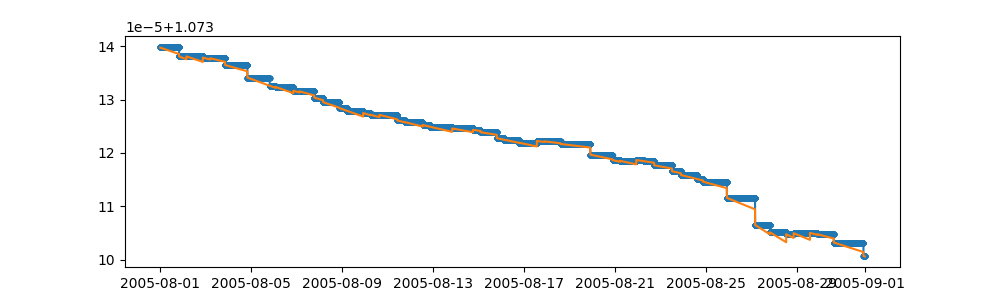

In [32]:
plt.figure(figsize = [10,3])
# plt.plot(GRACE_Data['Latitude (deg)'])
plt.plot(df_in['semi_major_axis'],'-o',ms=3)
plt.plot(time_array,semi_major_axis)